In [ ]:
#import Google drive
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#change the current working directory to the dataset directory
#for dataset downloading: https://www.kaggle.com/liftofff9/voice-gender
import os
os.chdir('/content/drive/My Drive/pygender')
!ls

data  mfcc_features_test.csv   test_data   Untitled0.ipynb
logs  mfcc_features_train.csv  train_data


In [ ]:
#import the required libraries
import librosa
import pickle
import pandas as pd
import numpy as np
import librosa.display
import matplotlib.pyplot as plt


from scipy.io.wavfile import read
from sklearn import preprocessing

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,  Conv1D, MaxPooling1D, Flatten,InputLayer
from keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
#Explanatory analysis about the recorded time of the dataset
female_audio,sample_rate1=librosa.core.load('/content/drive/My Drive/pygender/train_data/female/female1.wav')

#find the train record duration
duration_train = librosa.core.get_duration(female_audio, sample_rate1)
print("One audio training audio duration: ", np.round(duration_train), "sec")

#find the whole recording time for the training set
print("The whole training audio duration: ", np.round((duration_train * 10)/60), "minutes" )



test_audio,sample_rate2=librosa.core.load('/content/drive/My Drive/pygender/test_data/female_clips/-_m_h0DBaxw.wav')

#find the test record duration
duration_test = librosa.core.get_duration(test_audio, sample_rate2)
print("One audio testing audio duration: ", np.round(duration_test), "sec")

#find the whole recording time for the testing set
audio_test=(duration_test * 1131)/60
print("The whole testing audio duration: ", int(np.round(audio_test/60)), "hours and ", int(np.round(audio_test%60)), "minutes")

One audio training audio duration:  60.0 sec
The whole training audio duration:  10.0 minutes
One audio testing audio duration:  10.0 sec
The whole testing audio duration:  3 hours and  8 minutes


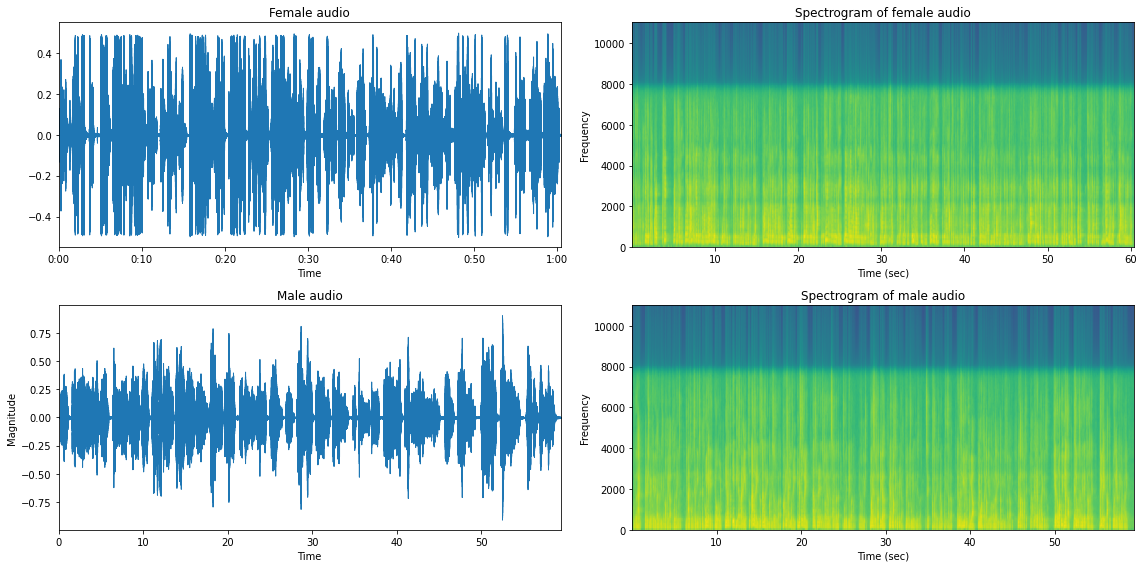

In [43]:
#Audio visualization
#Plotting audio signal and the spectrum of male and female audio in frequency domain 
female_audio,sample_rate1=librosa.core.load('/content/drive/My Drive/pygender/train_data/female/female1.wav')
male_audio, sample_rate2=librosa.core.load('/content/drive/My Drive/pygender/train_data/male/male1.wav')


if not os.path.isdir(dirname):
      os.makedirs(dirname)

plt.figure(figsize=(16,8))
plt.subplot(221)
librosa.display.waveplot(female_audio,sample_rate1,max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)
plt.title("Female audio")

plt.subplot(222)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(female_audio, Fs=sample_rate1)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Spectrogram of female audio')

plt.subplot(223)
librosa.display.waveplot(male_audio,sample_rate2, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)
plt.ylabel('Magnitude')
plt.title("Male audio")

plt.subplot(224)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(male_audio, Fs=sample_rate2)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title("Spectrogram of male audio")

plt.tight_layout()

plt.savefig('spectrum')

plt.show()   

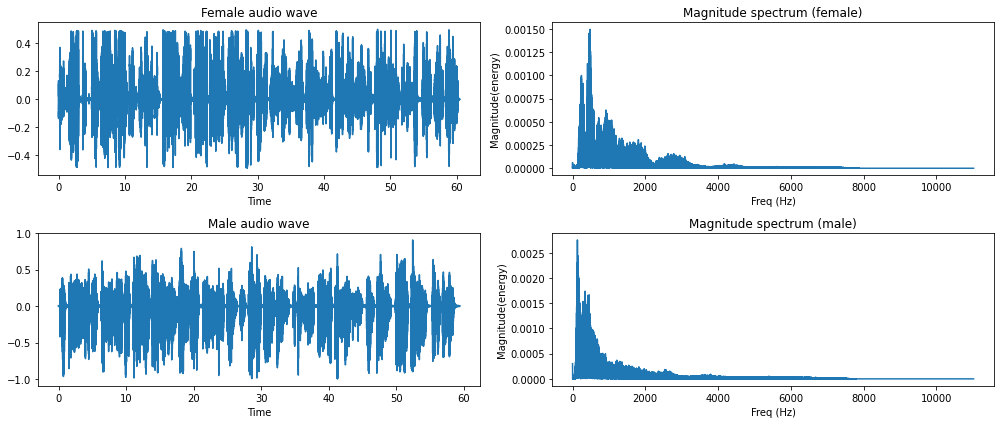

In [ ]:
#Audio visualization
#Plotting audio signal and the magnitude spectrum of male and female audio 
female_audio,sample_rate1=librosa.core.load('/content/drive/My Drive/pygender/train_data/female/female1.wav')
male_audio, sample_rate2=librosa.core.load('/content/drive/My Drive/pygender/train_data/male/male1.wav')

t = np.arange(len(female_audio)) / float(sample_rate1)
t2 = np.arange(len(male_audio)) / float(sample_rate2)

plt.figure(figsize=(14,6))
plt.subplot(2, 2, 1)
plt.plot(t, female_audio)
plt.xlabel('Time')
plt.title('Female audio wave')


plt.subplot(2, 2, 2)
plt.magnitude_spectrum(female_audio, Fs = sample_rate1) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude(energy)')
plt.title("Magnitude spectrum (female)")

plt.subplot(2, 2, 3)
plt.plot(t2, male_audio)
plt.xlabel('Time')
plt.title('Male audio wave')


plt.subplot(2, 2, 4)
plt.magnitude_spectrum(male_audio, Fs = sample_rate2) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude(energy)')
plt.title("Magnitude spectrum (male)")

plt.tight_layout()

plt.savefig('magnitude_spec')
plt.show()


In [ ]:
#a method for extracting a feature voice. 
#example: feature= feature_extraction("path/to/audiofie", "tonnetz")
#params
#feature_name: ["mfcc", "mel", "chroma", "tonnetz", "contrast"]
#file_name: path to the audio file
def feature_extraction(file_name, featuer_name):
  

  audio, sample_rate = librosa.core.load(file_name)
  EnrgSpectra = np.abs(librosa.stft(audio))
  result=np.asarray(())

  if featuer_name=="mfcc":
    features=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=25).T, axis=0)
    #rescale the data
    features=preprocessing.scale(features)
    #stack the feature arrays in a horizantal numpy array
    features=np.hstack((result,features))

  if featuer_name=="chroma":
    chroma=np.mean(librosa.feature.chroma_stft(S=EnrgSpectra, sr=sample_rate).T, axis=0)
    chroma=preprocessing.scale(chroma)
    features=np.hstack((result,chroma))
  
  if featuer_name=="mel":
    mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T, axis=0)
    mel=preprocessing.scale(mel)
    features=np.hstack((result,mel))

  if featuer_name=="tonnetz":
    tonnetz=np.mean(librosa.feature.tonnetz(y=audio,sr=sample_rate).T, axis=0)
    tonnetz=preprocessing.scale(tonnetz)
    features=np.hstack((result,tonnetz))
  if featuer_name=="contrast":
    contrast=np.mean(librosa.feature.spectral_contrast(y=audio,sr=sample_rate).T, axis=0)
    contrast=preprocessing.scale(contrast)
    features=np.hstack((result,contrast))
    
  return features

In [ ]:
#a method for extracting the feature voice for every audio file in the training or testing sets and save every feature's audio file in a speparate numpy file. 
#Then save the numpy files' paths in a csv file
#example: data_feature_preperation( "train", "chroma")
#params:
#train_or_test: ["train", "test"], feature_name: ["mfcc", "mel", "chroma", "tonnetz", "contrast"]
def data_feature_preperation(train_or_test, feature_name ):

 
  if train_or_test=="train":
    #path of the female training set
    train_female_path='/content/drive/My Drive/pygender/train_data/female/'
    #path of the male training set
    train_male_path='/content/drive/My Drive/pygender/train_data/male/'
    #path to save the feature file path of every training audio file to csv file
    csvFile='/content/drive/My Drive/pygender/mfcc_features_train.csv'
    #directory path to save the training features' files 
    dirname="data/mfcc_train"
    
  elif train_or_test=="test":
    #path of the female testing set
    train_female_path='/content/drive/My Drive/pygender/test_data/female_clips/'
    #path of the male testing set
    train_male_path='/content/drive/My Drive/pygender/test_data/male_clips/'
    #path to save the feature file path of every testing audio file to csv file
    csvFile='/content/drive/My Drive/pygender/mfcc_features_test.csv'
    #directory path to save the testing features' files 
    dirname="data/mfcc_test"
  
  #extract and save the features of female files
  female_files=[os.path.join(train_female_path,f) for f in os.listdir(train_female_path) if f.endswith('.wav')]


  if not os.path.isdir(dirname):
      os.makedirs(dirname)

  df=pd.DataFrame()
  feature_file=list()
  label=list()
  
  for f in female_files:
    splited = os.path.split(f)
    
    audio_filename=splited[-1].split(".")[0]
    
    mfcc=feature_extraction(f, feature_name)

    dest_path=f"{dirname}/{audio_filename}"
    
    np.save(dest_path, mfcc)

    feature_file.append(dest_path+".npy")
    label.append("female")

  #extract and save the features of male files
  male_files=[os.path.join(train_male_path,f) for f in os.listdir(train_male_path) if f.endswith('.wav')]

  for f in male_files: 
    mfcc=feature_extraction(f, feature_name)

    splited = os.path.split(f)
    
    audio_filename=splited[-1].split(".")[0]

    dest_path=f"{dirname}/{audio_filename}"

    np.save(dest_path, mfcc)

    feature_file.append(dest_path+".npy")
    label.append("male")

  df['file_feature_name']=feature_file
  df['gender']=label

  df.to_csv(csvFile)


In [ ]:
#method to save features of every audio file in one numpy array
#axample: save_data("test") 
#params:
#train_or_test: ["train", 'test]
def save_data(train_or_test):
  if train_or_test=="train":
    csvFile="/content/drive/My Drive/pygender/mfcc_features_train.csv"
    npFeatureFile="data/all_mfcc_train"
    npLabelFile="data/all_label_train"
  elif train_or_test=="test":
    csvFile="/content/drive/My Drive/pygender/mfcc_features_test.csv"
    npFeatureFile="data/all_mfcc_test"
    npLabelFile="data/all_label_test"
  df=pd.read_csv(csvFile)

  Y_train= np.zeros((len(df),1))
  X_train=np.zeros((len(df),25))

  for i, (file_name, gender) in enumerate(zip(df['file_feature_name'], df['gender'])):
    mfccFeature=np.load(file_name)  
    
    X_train[i]=mfccFeature

    if gender== "female":
      Y_train[i]=1
    else:
      Y_train[i]=0

  np.save(npFeatureFile, X_train)
  np.save(npLabelFile, Y_train)

  return X_train, Y_train

In [13]:
#metho to load training or testing files
def load_data(train_or_test):
  if train_or_test=="train":
    npFeatureFile="data/all_mfcc_train.npy"
    npLabelFile="data/all_label_train.npy"
  elif train_or_test=="test":
    npFeatureFile="data/all_mfcc_test.npy"
    npLabelFile="data/all_label_test.npy"

  X_train=np.load(npFeatureFile)
  Y_train=np.load(npLabelFile)
  
  return X_train, Y_train

In [ ]:

data_feature_preperation(train_or_test="train", feature_name="mfcc")
save_data(train_or_test="train")


In [ ]:
data_feature_preperation(train_or_test="test", feature_name="mfcc")
save_data(train_or_test="test")

In [26]:
#loading the testing and training sets
X_train,Y_train=load_data(train_or_test="train")
X_test,Y_test=load_data(train_or_test="test")

#makes the random numbers predictable
np.random.seed(5)

In [ ]:
#hyperparameters finetuning for XGBClassifier using GridSearchCV algorithm

param_grid={'learning_rate':[.0001,.1,.2,.5], 'n_estimators':[20,50,100,150,300], 'warm_start':[True, False]}
xgb=XGBClassifier()
xgb_cv=GridSearchCV(xgb, param_grid, cv=5)
xgb_cv.fit(X_train, Y_train.ravel())

#model_name="mfcc_model.sav"
#pickle.dump(xgb_cv, open(model_name, 'wb'))

print(xgb_cv.best_params_)
print(xgb_cv.best_score_)

{'learning_rate': 0.0001, 'n_estimators': 20, 'warm_start': True}
0.5


In [ ]:
#training and testing the data set using the best prameters of the XGBClassifier

# Initialize the classifier
xgb=XGBClassifier(learning_rate= 0.0001, n_estimators= 20, warm_start= True)

# Train the classifier
xgb.fit(X_train, Y_train.ravel())

# Make predictions
Y_pred=xgb.predict(X_test)

# Evaluate accuracy
print(accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

0.6843033509700176
              precision    recall  f1-score   support

         0.0       0.73      0.60      0.66       576
         1.0       0.65      0.77      0.71       558

    accuracy                           0.68      1134
   macro avg       0.69      0.69      0.68      1134
weighted avg       0.69      0.68      0.68      1134

[[345 231]
 [127 431]]


In [ ]:
#training and testing the data set using the GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators= 600, max_depth=1,max_features=1, min_samples_split=2,
              learning_rate= .001)

gb.fit(X_train, Y_train.ravel())

Y_pred=gb.predict(X_test)

print(accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

0.6331569664902998
              precision    recall  f1-score   support

         0.0       0.71      0.48      0.57       576
         1.0       0.60      0.79      0.68       558

    accuracy                           0.63      1134
   macro avg       0.65      0.64      0.62      1134
weighted avg       0.65      0.63      0.62      1134

[[275 301]
 [115 443]]


In [22]:
#hyperparameters finetuning for DecisionTreeClassifier using GridSearchCV algorithm

param_grid={"criterion":["gini", "entropy"],  "max_depth": np.arange(1,5),"max_features":["auto", "sqrt", "log2"]}
dtr=DecisionTreeClassifier()

xgb_cv=GridSearchCV(dtr, param_grid, cv=5)
xgb_cv.fit(X_train, Y_train.ravel())

#model_name="mfcc_model.sav"
#pickle.dump(xgb_cv, open(model_name, 'wb'))

print(xgb_cv.best_params_)
print(xgb_cv.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto'}
0.9


In [25]:
#training and testing the data set using the best prameters of the DecisionTreeClassifier

dtr=DecisionTreeClassifier( max_depth=3, max_features='log2',criterion="gini",random_state=50).fit(X_train,Y_train)

Y_pred=dtr.predict(X_test)

print(accuracy_score(Y_test, Y_pred))

0.5731922398589065


In [35]:
#hyperparameters tuning for a created NN model

epochs=35
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.8

#initialize optimizer
sgd = Adam(lr=learning_rate)

def create_model(init_mode='uniform'):
    vector_length=25

    model = Sequential()
    model.add(Dense(256, kernel_initializer=init_mode,input_shape=(vector_length,)))
    model.add(Dense(256,kernel_initializer=init_mode, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, kernel_initializer=init_mode,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,kernel_initializer=init_mode, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, kernel_initializer=init_mode,activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 1 means female, 0 means male
    model.add(Dense(1, kernel_initializer=init_mode,activation="sigmoid"))

    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=sgd)
   
    return model


model_CV = KerasClassifier(build_fn=create_model, verbose=1)

# define the grid search parameters
init_mode = ['huniform' ,'lecun_uniform']
batches = [10,5]
epochs = [10,30,40,60,75,80]

param_grid = dict(epochs=epochs, batch_size=batches,init_mode=init_mode)

grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, Y_train)

#print the best hyperparameters' values of the model
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/75
1/1 [==============================] - 0s 2ms/step - loss: 0.7857 - accuracy: 0.4000
Epoch 2/75
1/1 [==============================] - 0s 1ms/step - loss: 0.8143 - accuracy: 0.3000
Epoch 3/75
1/1 [==============================] - 0s 998us/step - loss: 0.6511 - accuracy: 0.7000
Epoch 4/75
1/1 [==============================] - 0s 2ms/step - loss: 0.5713 - accuracy: 0.7000
Epoch 5/75
1/1 [==============================] - 0s 1ms/step - loss: 0.6763 - accuracy: 0.6000
Epoch 6/75
1/1 [==============================] - 0s 2ms/step - loss: 0.8869 - accuracy: 0.3000
Epoch 7/75
1/1 [==============================] - 0s 1ms/step - loss: 0.7681 - accuracy: 0.4000
Epoch 8/75
1/1 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.4000
Epoch 9/75
1/1 [==============================] - 0s 972us/step - loss: 0.6360 - accuracy: 0.7000
Epoch 10/75
1/1 [==============================] - 0s 2ms/step - loss: 0.7920 - accuracy: 0.3000
Epoch 11/75
1/1 [==================

In [38]:
#train and test the model using the best parameters
learning_rate = 0.001
momentum = 0.8

sgd = Adam(lr=learning_rate)

def create_model(init_mode='lecun_uniform'):
    vector_length=25
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, kernel_initializer=init_mode,input_shape=(vector_length,)))
    model.add(Dense(256,kernel_initializer=init_mode, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, kernel_initializer=init_mode,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,kernel_initializer=init_mode, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, kernel_initializer=init_mode,activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, kernel_initializer=init_mode,activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=sgd)
    # print summary of the model
   
    return model


model=create_model()

model.fit(X_train,Y_train, batch_size=10, epochs=75, verbose=1)

loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print("Loss:", loss)
print("Accuracy: ",accuracy*100)

Epoch 1/75
1/1 [==============================] - 0s 2ms/step - loss: 0.8071 - accuracy: 0.6000
Epoch 2/75
1/1 [==============================] - 0s 4ms/step - loss: 0.8136 - accuracy: 0.5000
Epoch 3/75
1/1 [==============================] - 0s 2ms/step - loss: 0.7592 - accuracy: 0.6000
Epoch 4/75
1/1 [==============================] - 0s 2ms/step - loss: 0.7385 - accuracy: 0.5000
Epoch 5/75
1/1 [==============================] - 0s 2ms/step - loss: 0.6717 - accuracy: 0.6000
Epoch 6/75
1/1 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.6000
Epoch 7/75
1/1 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5000
Epoch 8/75
1/1 [==============================] - 0s 2ms/step - loss: 0.7408 - accuracy: 0.6000
Epoch 9/75
1/1 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.6000
Epoch 10/75
1/1 [==============================] - 0s 1ms/step - loss: 0.7155 - accuracy: 0.5000
Epoch 11/75
1/1 [======================